In [1]:
# This Notebook is for experimenting with features & trying to improve boosting models
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
pd.set_option('display.max_columns', None)
import joblib
import optuna
import torch


In [2]:
# TODO: lookup sentiment
# TODO: text feature (TF-IDF)
# TODO: forward selection: use only features that improves kappa
# Target encoding
def featurize_table(data_df):
    tabular_df = data_df.copy()
    # Namelength
    tabular_df["name_length"] = tabular_df['Name'].str.len().fillna(0)
    
    # Description length
    tabular_df['description_length'] = tabular_df['Description'].str.len().fillna(0)
    
    # Is Mixed Breed? (Breed2 is not 0)
    tabular_df['is_mixed_breed'] = (tabular_df['Breed2'] != 0).astype(int)
    
    
    
    # 1. Text
    tabular_df['word_count'] = tabular_df['Description'].str.split().str.len().fillna(0)
    tabular_df['char_count'] = tabular_df['Description'].str.len().fillna(0)
    tabular_df['avg_word_len'] = tabular_df['char_count'] / (tabular_df['word_count'] + 1)
    tabular_df['num_digits'] = tabular_df['Description'].apply(lambda x: sum(c.isdigit() for c in str(x)))
    tabular_df['all_caps_ratio'] = tabular_df['Description'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / max(1, len(str(x))))

    # 2. Measures
    tabular_df['fee_per_pet'] = tabular_df['Fee'] / tabular_df['Quantity'].replace(0,1)
    tabular_df['photo_per_pet'] = tabular_df['PhotoAmt'] / tabular_df['Quantity']
    tabular_df['age_per_size'] = tabular_df['Age'] / tabular_df['MaturitySize'] # Needs careful handling of 0s
    tabular_df['total_media'] = tabular_df['PhotoAmt'] + tabular_df['VideoAmt'] # Total Media (Engagement proxy)
    tabular_df['num_colors'] = (tabular_df[['Color1', 'Color2', 'Color3']] != 0).sum(axis=1) # Number of Colors (Count non-zero color columns)
    
    
    # 3. Simple Interactions
    tabular_df['is_mixed_breed'] = (tabular_df['Breed2'] != 0) & (tabular_df['Breed2'].notnull())
    tabular_df['is_specific_color'] = (tabular_df['Color2'] != 0) # Has more than 1 color    
    tabular_df['is_free'] = (tabular_df['Fee'] == 0).astype(int)    # Is Free? (Fee is 0)
    tabular_df['has_health_issue'] = (tabular_df['Health'] > 1).astype(int)   # Health Issue Flag (Health > 1 implies injury or condition)
    
    # log transform for shit and giggles
    tabular_df['Fee'] = np.log1p(tabular_df['Fee'])
    tabular_df['PhotoAmt'] = np.log1p(tabular_df['PhotoAmt'])
    
    # Drop useless features -> does this actually works?
    features_to_drop = [""]
    
    # Encode categories
    cat_cols = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 
                    'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 
                    'Sterilized', 'Health', 'State']
    for col in cat_cols:
        if col in tabular_df.columns:
            tabular_df[col] = tabular_df[col].astype('category')
        

    tabular_df.drop(['Name', 'PetID', 'Description', "RescuerID"], axis=1, inplace=True)
    return tabular_df


In [3]:
# Advanced Features
def extract_sentiment_from_json(pet_id, sentiment_dir="../data/train_sentiment/"):
    # This assumes the sentiment files follow the pattern {PetID}.json
    filename = f"{sentiment_dir}/{pet_id}.json"
    try:
        if os.path.exists(filename):
            with open(filename, 'r') as f:
                data = json.load(f)
            # Usually 'documentSentiment' holds the overall score
            if 'documentSentiment' in data:
                return data['documentSentiment']['score'], data['documentSentiment']['magnitude']
    except:
        pass
    return 0, 0 # Default if missing


def generate_text_features(df, svd_components=20, is_train=True, fit_on_text=None):
    """
    df: The dataframe (containing 'Description' and 'PetID')
    svd_components: Number of latent features to keep
    is_train: Boolean, used to decide whether to fit or transform
    fit_on_text: If is_train=False, pass the vectorizers here (tuple: tfidf, svd)
    """
    df_text = df.copy()
    
    # 1. TF-IDF + SVD (Latent Semantic Analysis)
    print("Generating TF-IDF SVD features...")
    descriptions = df_text['Description'].fillna("none").astype(str)
    
    if is_train:
        # Fit on TRAINING descriptions
        tfidf = TfidfVectorizer(min_df=3,  max_features=1000, 
                                strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                                ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True,
                                stop_words = 'english')
        
        svd = TruncatedSVD(n_components=svd_components, random_state=42)
        
        # Fit Transform
        tf_vecs = tfidf.fit_transform(descriptions)
        svd_vecs = svd.fit_transform(tf_vecs)
        
        # Save vectorizers for inference later
        vectorizers = (tfidf, svd)
    else:
        # Load from passed tuple
        tfidf, svd = fit_on_text
        tf_vecs = tfidf.transform(descriptions)
        svd_vecs = svd.transform(tf_vecs)
        vectorizers = fit_on_text

    # Create Columns
    svd_df = pd.DataFrame(svd_vecs, columns=[f'svd_desc_{i}' for i in range(svd_components)])
    # We reset index to make sure concat aligns correctly row-by-row
    df_text = pd.concat([df_text.reset_index(drop=True), svd_df], axis=1)

    # 2. Sentiment Analysis (File-based lookup)
    # Determine directory
    sent_dir = "../data/train_sentiment" if is_train else "../data/test_sentiment"
    
    print("Extracting Sentiment...")
    # Apply row-wise (can be slow, maybe parallelize with pandarallel if needed)
    sent_data = df_text['PetID'].apply(lambda x: extract_sentiment_from_json(x, sent_dir))
    
    df_text['sentiment_score'] = [x[0] for x in sent_data]
    df_text['sentiment_magnitude'] = [x[1] for x in sent_data]
    df_text['sentiment_polarity'] = df_text['sentiment_score'] * df_text['sentiment_magnitude']

    return df_text, vectorizers

In [4]:
# Load Data
full_df = pd.read_csv("../data/train/train.csv") #Beware of directory

# Splitting the data from train.csv
X = full_df.drop(['AdoptionSpeed'], axis=1)
y = full_df['AdoptionSpeed'] 
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Generate  Features
X_train_text, vec_tuple = generate_text_features(X_train_raw, is_train=True)
X_test_text, _ = generate_text_features(X_test_raw,is_train=False, fit_on_text=vec_tuple)


X_train = featurize_table(X_train_text)
X_test = featurize_table(X_test_text)
X_train

Generating TF-IDF SVD features...
Extracting Sentiment...
Generating TF-IDF SVD features...
Extracting Sentiment...


,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,svd_desc_0,svd_desc_1,svd_desc_2,svd_desc_3,svd_desc_4,svd_desc_5,svd_desc_6,svd_desc_7,svd_desc_8,svd_desc_9,svd_desc_10,svd_desc_11,svd_desc_12,svd_desc_13,svd_desc_14,svd_desc_15,svd_desc_16,svd_desc_17,svd_desc_18,svd_desc_19,sentiment_score,sentiment_magnitude,sentiment_polarity,name_length,description_length,is_mixed_breed,word_count,char_count,avg_word_len,num_digits,all_caps_ratio,fee_per_pet,photo_per_pet,age_per_size,total_media,num_colors,is_specific_color,is_free,has_health_issue
0,1,2,307,307,1,1,0,0,2,2,2,1,2,1,3,0.0,41326,0,2.197225,0.244532,-0.037060,0.008682,0.020883,0.126230,0.017125,0.043185,0.036605,0.047601,-0.051458,-0.064420,0.069778,-0.011776,-0.090580,-0.023213,-0.160635,-0.080065,0.086479,-0.009234,0.052999,0,0,0,17.0,450.0,True,80.0,450.0,5.555556,4,0.008889,0.0,2.666667,1.0,8.0,1,False,1,0
1,1,12,307,0,2,2,0,0,1,1,1,1,1,1,1,0.0,41326,0,1.386294,0.129967,-0.014390,-0.011191,0.214028,-0.024347,0.093595,-0.125752,0.019212,-0.016720,0.074427,0.200051,0.089453,0.019649,-0.018445,-0.122734,-0.038898,-0.004980,-0.025647,-0.053705,-0.021235,0,0,0,5.0,77.0,False,12.0,77.0,5.923077,0,0.038961,0.0,3.000000,12.0,3.0,1,False,1,0
2,1,2,307,307,1,1,2,7,2,1,2,2,2,1,1,0.0,41326,0,0.693147,0.036105,0.006319,0.009052,-0.040065,0.043863,0.006899,-0.002840,0.006765,0.023516,-0.024033,0.026478,0.035405,-0.059616,-0.016858,-0.010160,-0.060419,0.012564,0.026524,-0.009877,0.079327,0,0,0,11.0,29.0,True,5.0,29.0,4.833333,0,0.137931,0.0,1.000000,1.0,1.0,3,True,1,0
3,1,2,307,307,1,3,0,0,2,2,1,1,2,1,1,0.0,41326,0,1.098612,0.230322,0.946186,0.060190,0.014545,-0.101189,-0.003106,0.061647,0.002062,0.002932,-0.037770,0.000950,-0.022837,0.026151,0.017754,0.032926,0.068430,-0.074480,-0.007891,0.010836,0.008565,0,0,0,6.0,12.0,True,2.0,12.0,4.000000,0,0.083333,0.0,2.000000,1.0,2.0,1,False,1,0
4,2,4,265,0,3,1,2,0,2,2,2,2,2,1,4,0.0,41326,0,1.098612,0.136872,0.353950,-0.019017,-0.113207,-0.015904,-0.024246,0.053143,-0.041385,0.047071,0.111267,-0.043739,0.015210,0.024690,-0.049469,-0.065180,-0.037186,-0.137048,-0.122686,0.068733,-0.073205,0,0,0,11.0,20.0,False,3.0,20.0,5.000000,0,0.050000,0.0,0.500000,2.0,2.0,2,True,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11989,2,8,265,299,2,1,2,0,2,2,1,1,2,1,1,0.0,41326,0,1.098612,0.205444,-0.049414,-0.057199,0.036065,0.039162,0.026868,0.063012,-0.002587,-0.046638,-0.040758,0.061714,-0.104008,0.038616,-0.016623,0.024413,-0.001041,0.036241,-0.085281,-0.118394,-0.003344,0,0,0,6.0,340.0,True,66.0,340.0,5.074627,1,0.014706,0.0,2.000000,4.0,2.0,2,True,1,0
11990,1,2,307,0,2,6,7,0,1,1,2,1,3,1,1,0.0,41326,0,0.693147,0.224184,-0.049292,0.025368,0.003476,0.110897,0.027647,0.018800,-0.007240,0.129459,-0.085259,-0.065398,0.126936,-0.033020,0.036416,0.069005,0.006937,0.017209,-0.002086,-0.028476,-0.054225,0,0,0,6.0,313.0,False,63.0,313.0,4.890625,1,0.015974,0.0,1.000000,2.0,1.0,2,True,1,0
11991,1,2,307,307,1,1,0,0,2,2,1,1,2,1,1,0.0,41401,0,1.098612,0.161576,-0.049235,0.056162,0.033361,-0.003143,-0.019945,0.108630,0.023962,0.007483,-0.087941,-0.011080,-0.015146,0.019132,-0.032981,-0.071715,-0.088255,0.021091,0.036146,0.006831,0.019530,0,0,0,8.0,284.0,True,50.0,284.0,5.568627,0,0.021127,0.0,2.000000,1.0,2.0,1,False,1,0
11992,1,2,307,307,1,1,2,7,2,2,2,2,2,1,1,0.0,41326,0,1.098612,0.163324,-0.050198,-0.018858,0.013617,0.006744,-0.046310,0.054158,-0.027762,0.085841,0.020232,-0.038258,-0.070167,0.044753,-0.022347,-0.082730,0.003721,-0.048951,-0.022561,0.039550,0.035044,0,0,0,5.0,219.0,True,42.0,219.0,5.093023,0,0.027397,0.0,2.000000,1.0,2.0,3,True,1,0


In [5]:
# Plan 1: normal classification
# Hyperparameter-tuning w/Optuna

# Calculate weights inversely proportional to class frequencies
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
def objective(trial):
    params = {
        # Config for how to predict
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 5,
        'tree_method': 'hist', # Faster training
        'enable_categorical': True,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu', # Use GPU if available
        
        # Tuning parameters
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000), # More trees, but early stopping handles it
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), # % of feature used per tree
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    # Split for early stopping (Optuna needs a validation set)
    # Using specific validation set (futher split from train set)
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, 
                                                stratify=y_train
                                                )

    # Choose regressor if trying to use with optimied rounder
    model = xgb.XGBClassifier(**params, early_stopping_rounds=50)
    
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    preds = model.predict(X_val)
    kappa = cohen_kappa_score(y_val, preds, weights='quadratic')
    return kappa

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 smart trials

print(f"Best trial value: {study.best_value}")
print(f"Best params: {study.best_params}")

# Use best params
best_params = study.best_params
# Add fixed params back
best_params['objective'] = 'multi:softprob'
best_params['num_class'] = 5

xgb_optuna = xgb.XGBClassifier(**best_params)
xgb_optuna.fit(X_train, y_train, sample_weight=sample_weights) 
pred_xgb = xgb_optuna.predict(X_test)
#joblib.dump(xgb_optuna, 'xgb_optuna_full.pkl')

[I 2026-02-17 11:31:52,003] A new study created in memory with name: no-name-3da874a7-d9ea-47ec-848c-58c07eff9ccc
[I 2026-02-17 11:32:04,633] Trial 0 finished with value: 0.3719605109380171 and parameters: {'n_estimators': 997, 'learning_rate': 0.011951864143811811, 'max_depth': 11, 'subsample': 0.9272574080497135, 'colsample_bytree': 0.6855093471652878, 'min_child_weight': 7, 'reg_alpha': 9.186164802873634, 'reg_lambda': 0.5448364770333247}. Best is trial 0 with value: 0.3719605109380171.
[I 2026-02-17 11:32:05,574] Trial 1 finished with value: 0.31714814975499195 and parameters: {'n_estimators': 225, 'learning_rate': 0.020504392473500964, 'max_depth': 3, 'subsample': 0.6319230076643224, 'colsample_bytree': 0.861486012704175, 'min_child_weight': 6, 'reg_alpha': 3.849737180518853, 'reg_lambda': 2.397552444737702}. Best is trial 0 with value: 0.3719605109380171.
[I 2026-02-17 11:32:11,267] Trial 2 finished with value: 0.38802932729591766 and parameters: {'n_estimators': 964, 'learning_r

Best trial value: 0.4007309922299208
Best params: {'n_estimators': 802, 'learning_rate': 0.03383838205478241, 'max_depth': 8, 'subsample': 0.7357559562899505, 'colsample_bytree': 0.8935309538030968, 'min_child_weight': 4, 'reg_alpha': 1.5664188641756576, 'reg_lambda': 3.3922880404788014}


In [6]:
# Plan 2: reg with optimized rounder
# Hyperparameter-tuning w/Optuna (Regressor)
import optuna
# Spaghetti split 
X_train_model, X_val_rounder, y_train_model, y_val_rounder = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        #'num_class': 5,
        'tree_method': 'hist', # Faster training
        'device': 'cuda' if torch.cuda.is_available() else 'cpu', # Use GPU if available
        # Tuning parameters
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000), # More trees, but early stopping handles it
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    # Split for early stopping (Optuna needs a validation set)
    # Using specific validation set
    X_tr, X_val, y_tr, y_val = train_test_split(X_train_model, y_train_model, test_size=0.1, random_state=42, 
                                                stratify=y_train_model
                                                )

    # Choose regressor if trying to use with optimied rounder
    model = xgb.XGBRegressor(**params, early_stopping_rounds=50)
    
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # FIXED: Round continuous predictions to integers for Kappa calculation
    preds = model.predict(X_val)
    preds_rounded = np.rint(preds).astype(int).clip(0, 4) 
    kappa = cohen_kappa_score(y_val, preds_rounded, weights='quadratic')
    return kappa

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 smart trials

print(f"Best trial value: {study.best_value}")
print(f"Best params: {study.best_params}")

# Use best params
best_params = study.best_params
# Add fixed params back
best_params['objective'] = 'reg:squarederror'

xgb_optuna_reg = xgb.XGBRegressor(**best_params)
xgb_optuna_reg.fit(X_train_model, y_train_model) 
pred_xgb_reg_raw = xgb_optuna_reg.predict(X_test)
pred_xgb_reg = np.rint(pred_xgb_reg_raw).astype(int).clip(0, 4)
#joblib.dump(xgb_optuna_reg, 'xgb_optuna_reg_full.pkl')

[I 2026-02-17 11:35:59,346] A new study created in memory with name: no-name-9f943738-19ec-4f0e-bba7-973e52a48ab8
[I 2026-02-17 11:36:00,295] Trial 0 finished with value: 0.2949105159373986 and parameters: {'n_estimators': 687, 'learning_rate': 0.1055411617171871, 'max_depth': 11, 'subsample': 0.9135351179211813, 'colsample_bytree': 0.9604970339923872, 'min_child_weight': 10, 'reg_alpha': 4.285253589632665, 'reg_lambda': 6.3406134346604865}. Best is trial 0 with value: 0.2949105159373986.
[I 2026-02-17 11:36:00,673] Trial 1 finished with value: 0.24174337480436103 and parameters: {'n_estimators': 315, 'learning_rate': 0.00623570532900732, 'max_depth': 3, 'subsample': 0.652453447890556, 'colsample_bytree': 0.9242147436851981, 'min_child_weight': 1, 'reg_alpha': 2.5739981929948694, 'reg_lambda': 3.234445319820336}. Best is trial 0 with value: 0.2949105159373986.
[I 2026-02-17 11:36:01,573] Trial 2 finished with value: 0.265380508961779 and parameters: {'n_estimators': 547, 'learning_rate

Best trial value: 0.3454100634997985
Best params: {'n_estimators': 463, 'learning_rate': 0.037618246770385215, 'max_depth': 12, 'subsample': 0.9469225998552627, 'colsample_bytree': 0.8532680870871938, 'min_child_weight': 3, 'reg_alpha': 1.1711008220326922, 'reg_lambda': 4.032520765936057}


In [7]:
# Rounder for regressor -> final label
# TODO: this creates leak?!
from oprounder import OptimizedRounder

# for fitting the rounder
#pred_train_reg = xgb_optuna_reg.predict(X_train)
pred_val_rounder = xgb_optuna_reg.predict(X_val_rounder) 

# what we want to predict (eval)
pred_test_reg = xgb_optuna_reg.predict(X_test)

# Fit the Optimized Rounder on Training Data
rounder = OptimizedRounder(n_classes=y_train.nunique(), n_trials=100)
rounder.fit(pred_val_rounder, y_val_rounder) 


# View the learned thresholds
print(f'Optimal thresholds: {rounder.thresholds}')

# Predict on Test Data using the new thresholds
pred_reg_optimized = rounder.predict(pred_test_reg) # use the new threshold to pick label

# Compare how the new threshold improve kappa
kappa = cohen_kappa_score(y_test, pred_reg_optimized, weights='quadratic')
print(f'Optimal Quadratic kappa: {kappa:.4f}')

kappa = cohen_kappa_score(y_test, pred_xgb_reg, weights='quadratic')
print(f'Original Quadratic kappa: {kappa:.4f}')

Optimal thresholds: [1.63522598979427, 2.0705013285373433, 2.4501776297043762, 2.999355448856246]
Optimal Quadratic kappa: 0.4027
Original Quadratic kappa: 0.3069


# Evaluate

In [8]:
from sklearn.metrics import cohen_kappa_score, accuracy_score

def evaluate_model(model, model_prediction):
    print(f"Model: {model.__class__.__name__}")
    print(f"Kappa Score: {cohen_kappa_score(model_prediction, y_test, weights='quadratic'):.4f}")
    print(f"Accuracy Score: {accuracy_score(model_prediction, y_test):.4f}")
   
print (evaluate_model(xgb_optuna, pred_xgb))

print (evaluate_model(xgb_optuna_reg, pred_xgb_reg))
kappa = cohen_kappa_score(y_test, pred_reg_optimized, weights='quadratic')
print(f'Optimal Quadratic kappa: {kappa:.4f}')

Model: XGBClassifier
Kappa Score: 0.3727
Accuracy Score: 0.4305
None
Model: XGBRegressor
Kappa Score: 0.3069
Accuracy Score: 0.3188
None
Optimal Quadratic kappa: 0.4027


<Figure size 1200x600 with 0 Axes>

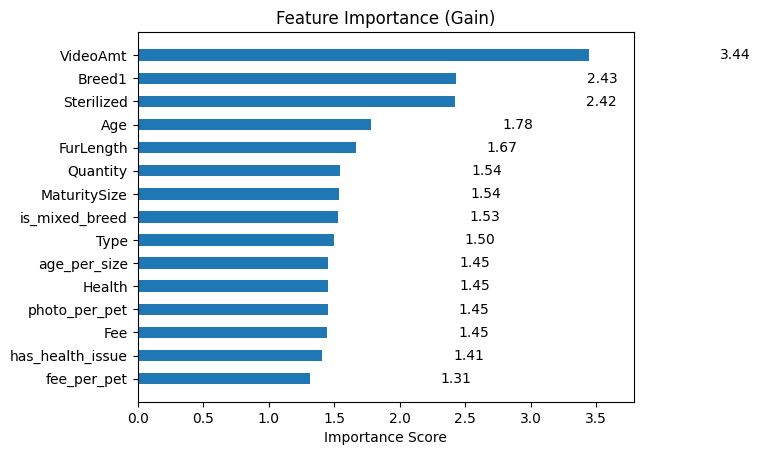

<Figure size 1200x600 with 0 Axes>

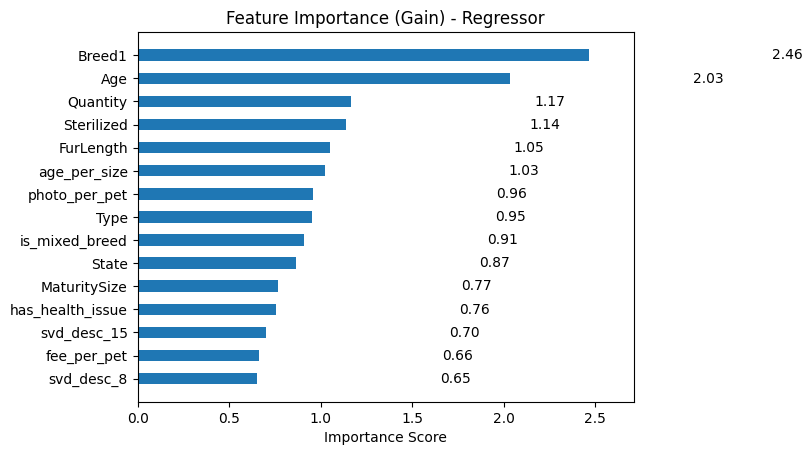

In [9]:
# Feature Importance: which factors benefit the prediction the most (extracted from XGBoost)
# ensure usage of original feature names not just np array indices
xgb_optuna.get_booster().feature_names = list(X_train.columns)

plt.figure(figsize=(12,6))
xgb.plot_importance(xgb_optuna, max_num_features=15, height=0.5, importance_type="gain", values_format = "{v:.2f}") # Weight ใช้อะไรมากที่สุดเป็นส่วนประกอบ tree, Gain อะไรแบ่งได้มากสุด
plt.title("Feature Importance (Gain)")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.grid(False)
plt.show()
# Also plot for the regressor model
xgb_optuna_reg.get_booster().feature_names = list(X_train.columns)

plt.figure(figsize=(12,6))
xgb.plot_importance(xgb_optuna_reg, max_num_features=15, height=0.5, importance_type="gain", values_format="{v:.2f}")
plt.title("Feature Importance (Gain) - Regressor")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.grid(False)
plt.show()

In [10]:
# Get feature importance from the classifier model
importance_dict = xgb_optuna.get_booster().get_score(importance_type='gain')

# Sort by importance (ascending to get the least important features)
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1])

# Get bottom 5 features
bottom_5 = sorted_importance[:5]

print("Bottom 5 least important features (by gain):")
for feature, importance in bottom_5:
    print(f"{feature}: {importance:.4f}")


print("Shit to drop:", [f for f, _ in bottom_5])

Bottom 5 least important features (by gain):
Color2: 0.8345
is_free: 0.8962
Vaccinated: 0.9202
num_colors: 0.9305
name_length: 0.9369
Shit to drop: ['Color2', 'is_free', 'Vaccinated', 'num_colors', 'name_length']
